![](camera.jpg)

# Stereo Camera

The EX8029 Stereo Camera from eYs3D is a depth-map imager controller and patterned IR illuminator capable of both color and point map output modes. Thanks to its dual cameras, this Stereo Camera is ideally used in applications involving motion and gesture control, field mapping, and 3D scanning. The best part about this module is the fact that it has been designed to be as straight forward and easy to use as possible for a stereo camera. Simply plug in the included USB 3.0 cable download the required files and start seeing things through the eyes of your new camera!

## References

- [eYs3D Stereo Camera - EX8029 datasheet](docs/EX8029_DataSheet_rev1.0_20170114.pdf)
- [Buy from Sparkfun.com](https://www.sparkfun.com/products/14726)
- [Stereo rectification tutorial](https://vgg.fiit.stuba.sk/2015-02/2783/)
- [OpenCV tutorial on depth maps](https://docs.opencv.org/3.4.3/dd/d53/tutorial_py_depthmap.html)
- [OpenCV tutorial on pose estimation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html)
- [caltech camera calibration docs](http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example.html)

# Parameters

We need to estimate some camera parameters, both internal and external.

## Intrinsics (Internal)

- **Camera Matrix (M):** this holds vital internal parameters such as:
    - **focal length (f):** measured in pixels for both the x and y direction
    - **principle point (c):** is the center of the image measured in pixels for both the x and y direction

There is only one focal length ($f$) and it is the distance between the focal point and the image plane. However, $f_x = f \cdot s_x$ and $f_y = f \cdot s_y$ where $s_x$ and $s_y$ are the size of your image in pixels. So $f_y = f_x \cdot a$ where $a$ is the aspect ratio of your image (width/height).

## Extrinsics (External)

These are parameters that releate how the cameras are positioned/oriented in the 3d world.

- **Rotation (R):** How the cameras are orientated between each other in angular space
- **Translation (T):** how the cameras are positioned (separated) in physical space 
- **Essential Matrix (E):** contains the information about translation and rotation between the 2 cameras in global coordinates.
- **Fundamental Matrix (F):** contains the same information as E, but also contains intrinsics of both cameras so that we can relate the two cameras in pixel coordinates.

## Pinhole Camera Model

\begin{eqnarray}
  s p' = A[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)

In [33]:
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def draw(l, r, lines=True, thickness=1):
    n = np.hstack((l, r))
    if len(n.shape) < 3:
        n = cv2.cvtColor(n, cv2.COLOR_GRAY2RGB)
    if lines:
        h, w = n.shape[:2]
        for r in range(0, h, 20):
            cv2.line(n,(0,r), (w,r), (200,0,0), thickness)
    return n

In [3]:
# img = cv2.imread('imgs-1/image-3.png')
img = cv2.imread('checkerboard-imgs/image-15.png')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h,w = img.shape
print(h,w)
imgL = img[:,:w//2]
imgR = img[:,w//2:]

(720, 2560, 3)
720 2560


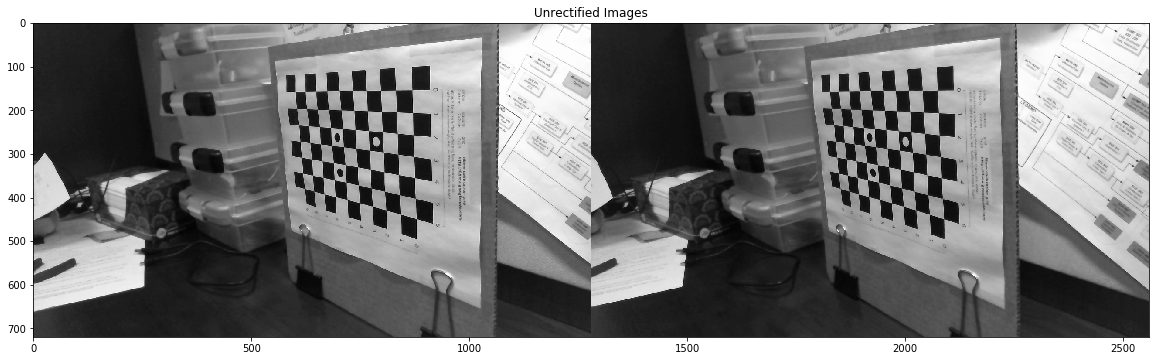

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(draw(imgL, imgR, lines=False), 'gray')
plt.title('Unrectified Images');

Camera Model keys: dict_keys(['date', 'markerType', 'markerSize', 'imageSize', 'cameraMatrix1', 'cameraMatrix2', 'distCoeffs1', 'distCoeffs2', 'R', 'T', 'E', 'F'])
['P1', 'P2', 'Q', '_Rectify__fix', '_Rectify__fix2', '_Rectify__read', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'alpha', 'info', 'maps_1', 'maps_2', 'maps_read', 'printParams', 'printStereoParams', 'project3d', 'undistort', 'undistortStereo']
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -5.50874011e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.07812565e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.32709592e+03]
 [ 0.00000000e+00  0.00000000e+00  3.18614187e+01 -0.00000000e+00]]
[[-0.03134446]
 [-0.0

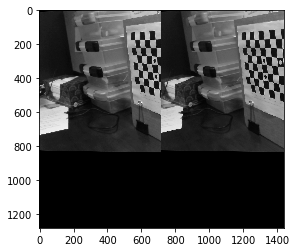

In [85]:
from camera_calibrate import Rectify, Markers

rc = Rectify("cb_camera_model.pickle")
imgLc, imgRc = rc.undistortStereo(imgL, imgR)
plt.imshow(draw(imgLc, imgRc, lines=False), 'gray')
print('Camera Model keys: {}'.format(rc.info.keys()))
print(dir(rc))
print(rc.Q)
print(rc.info['T'])

## SGBM 

[ref](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html#details)

The class implements the modified H. Hirschmuller algorithm [87] that differs from the original one as follows:

- By default, the algorithm is single-pass, which means that you consider only 5 directions instead of 8. Set mode=StereoSGBM::MODE_HH in createStereoSGBM to run the full variant of the algorithm but beware that it may consume a lot of memory.
- The algorithm matches blocks, not individual pixels. Though, setting blockSize=1 reduces the blocks to single pixels.
- Mutual information cost function is not implemented. Instead, a simpler Birchfield-Tomasi sub-pixel metric from [17] is used. Though, the color images are supported as well.
- Some pre- and post- processing steps from K. Konolige algorithm StereoBM are included, for example: pre-filtering (StereoBM::PREFILTER_XSOBEL type) and post-filtering (uniqueness check, quadratic interpolation and speckle filtering).

### Params

- **minDisparity:**	Minimum possible disparity value. Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
- **numDisparities:**	Maximum disparity minus minimum disparity. The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
- **blockSize:**	Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
- **P1:**	The first parameter controlling the disparity smoothness. See below.
- **P2:**	The second parameter controlling the disparity smoothness. The larger the values are, the smoother the disparity is. P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels. P2 is the penalty on the disparity change by more than 1 between neighbor pixels. The algorithm requires P2 > P1 . See stereo_match.cpp sample where some reasonably good P1 and P2 values are shown, like:
    - P1: $8 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
    - P2: $32 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
- **disp12MaxDiff:**	Maximum allowed difference (in integer pixel units) in the left-right disparity check. Set it to a non-positive value to disable the check.
- **preFilterCap:**	Truncation value for the prefiltered image pixels. The algorithm first computes x-derivative at each pixel and clips its value by [-preFilterCap, preFilterCap] interval. The result values are passed to the Birchfield-Tomasi pixel cost function.
- **uniquenessRatio:**	Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct. Normally, a value within the 5-15 range is good enough.
- **speckleWindowSize:**	Maximum size of smooth disparity regions to consider their noise speckles and invalidate. Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
- **speckleRange:**	Maximum disparity variation within each connected component. If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16. Normally, 1 or 2 is good enough.
- **mode:**	Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm. It will consume O(W\*H\*numDisparities) bytes, which is large for 640x480 stereo and huge for HD-size pictures. By default, it is set to `False`.

In [127]:
if False:
    window_size = 3
    min_disp = 16
    num_disp = 112-min_disp
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp, # Maximum disparity minus minimum disparity
       blockSize = 16,
       P1 = 8*3*window_size**2,  # parameters for disparity matching
       P2 = 32*3*window_size**2,
       disp12MaxDiff = 1,  # matching differences
       uniquenessRatio = 10,  # matching parameter
       speckleWindowSize = 50,  # filtering to remove speckles in an image
       speckleRange = 2
    )
else:
    maxdisp = 16*9
    mindisp = 16*3
    ndisp = maxdisp - mindisp
    blksize = 11
    window_size = 3*3
    stereo = cv2.StereoSGBM_create(numDisparities=ndisp, blockSize=blksize,
       P1 = 8*1*window_size**2,  # parameters for disparity matching
       P2 = 32*1*window_size**2,
       mode=True
    )
    
#     stereo = cv2.StereoSGBM_create(minDisparity=mindisp, numDisparities=ndisp, blockSize=blksize)

disparity = stereo.compute(imgL,imgR)

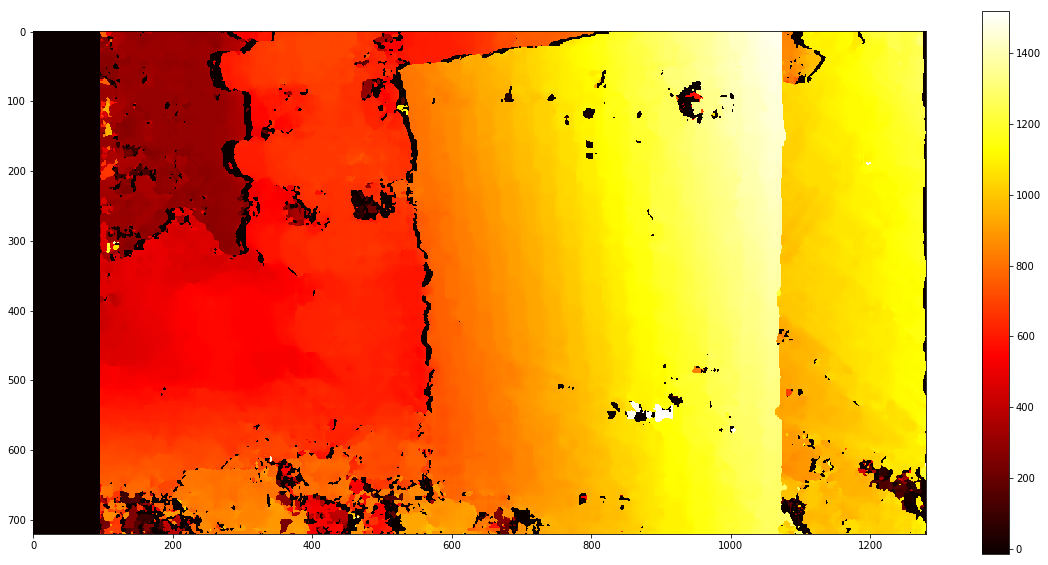

In [195]:
plt.figure(figsize=(20,10))
plt.imshow(disparity, cmap='hot')
plt.colorbar();

disp min/max: 0.0 95.0
disp: (720, 1280)
imgL (720, 1280)
[ Points (720, 1280, 3)]---------------------
 x min/max: -inf inf
 y min/max: -inf inf
 z min/max: 0.43844348 10000.0
colors: (720, 1280, 3)
--------------------------------------------------
filtered points min/max: -inf inf
filtered points: (720, 1280, 3)


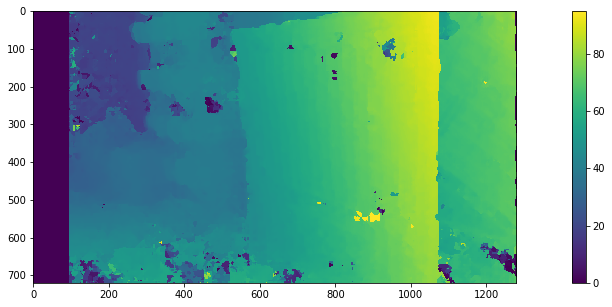

In [235]:
disp = stereo.compute(imgL, imgR).astype(np.float32)/16
mask = disp < 0
disp[mask] = 0
plt.imshow(disp)
plt.colorbar()

# h, w = imgLc.shape[:2]
# f = 0.8*w                          # guess for focal length
# Q = np.float32([[1, 0, 0, -0.5*w],
#                 [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
#                 [0, 0, 0,     -f], # so that y-axis looks up
#                 [0, 0, 1,      0]])

# disp = disparity
# disp = np.uint8(filteredImg)

print('disp min/max:', disp.min(), disp.max())
print('disp:', disp.shape)

points = cv2.reprojectImageTo3D(disp, rc.Q, handleMissingValues=True)
colors = cv2.cvtColor(imgL, cv2.COLOR_GRAY2RGB)
print('imgL', imgL.shape)

print('[ Points {}]---------------------'.format(points.shape))
print(' x min/max:', points[:,:,0].min(), points[:,:,0].max())
print(' y min/max:', points[:,:,1].min(), points[:,:,1].max())
print(' z min/max:', points[:,:,2].min(), points[:,:,2].max())
      

print('colors:', colors.shape)

print('-'*50)

# mask = disp < 4
# out_points = points[mask]
# out_colors = colors[mask]
# points[mask] = 200 # disp.max()


# colors[mask]
out_points = points
o = points


# mask = out_points < 1000
# o = out_points[mask]
# oc = out_colors[mask]


print('filtered points min/max:', out_points.min(), out_points.max())
print("filtered points:", out_points.shape)

# o = out_points
# # print(o[:,0])
# fig = plt.figure(figsize=(20,10))
# # ax = fig.gca(projection='3d')
# # ax.plot_surface(o[:,0],o[:,1],o[:,2])
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(o[:,0],o[:,1],o[:,2])
# # plt.show()

In [273]:
def getDistanceMap(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
    z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
    z = np.uint8(z)
    return z

def getDistanceMap2(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    x = points[:,:,0]
    x[x > sat] = sat
    
    y = points[:,:,1]
    y[y > sat] = sat
    
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
#     z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
#     z = np.uint8(z)
    return points, color

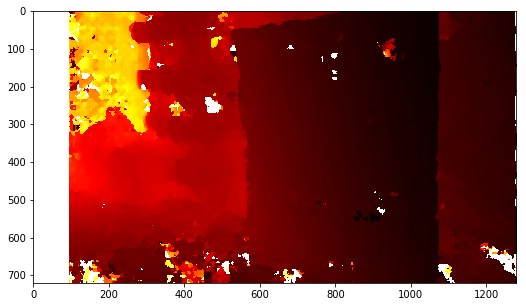

In [255]:
z = getDistanceMap(imgL, disp, rc.Q, 3)
plt.imshow(z, cmap='hot');

In [ ]:
ply = PLY()
ply.write('out.ply', out_points, out_colors)

# Focal Length

$$
f_{px} = f_{mm}*\frac{resolution}{sensorSize} \\
$$

| Parameter | Value |
|---|---|
| Sensor | OV9714 |
| Active Array Size | 1296 x 812 |
| Image Area | 3936 um x 2460 um |
| Camera Focal Length | 3.11 mm |

In [8]:
fx = 3.11*1296/(3936e-3)
fy = 3.11*812/(2460e-3)
print('Focal length (x,y) in pixels: {:.2f} {:.2f}'.format(fx, fy))

Focal length (x,y) in pixels: 1024.02 1026.55


# Pretty Disparity Map

Like above, you see depth maps with holes in them due to the camera setup. Generally, depth maps are only calculated using the left camera as the origin. [Here](http://timosam.com/python_opencv_depthimage) we are following a python version of the OpenCV tutorials and creating another depth map based on the right camera. Then we filter and combine the two so holes are filled.

In [323]:
def prettyDisparity(imgL, imgR, stereo, **kwargs):
    print(kwargs)
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
     # FILTER Parameters
    lmbda = kwargs.get('lamda',80000)
    sigma = kwargs.get('signam',1.2)
    visual_multiplier = kwargs.get('mult',1.0)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

#     print('computing disparity...')
    displ = stereo.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    # need to normalize the image, so its values are between 0-255
    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    # need to convert back to 8b integer values
    filteredImg = np.uint8(filteredImg)
    return filteredImg

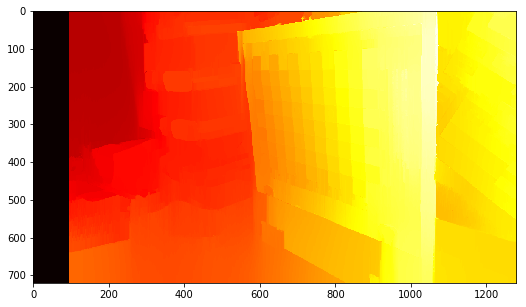

In [248]:
filteredImg = prettyDisparity(imgL, imgR, stereo)
plt.imshow(filteredImg, cmap='hot');

Text(0.5, 1.0, '(720, 1280)')

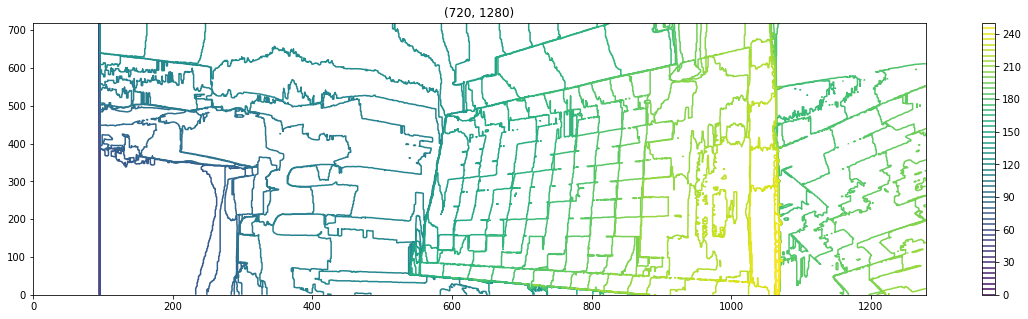

In [303]:
plt.contour(filteredImg, levels=range(0,255, 5))
plt.colorbar()
plt.title('{}'.format(filteredImg.shape))

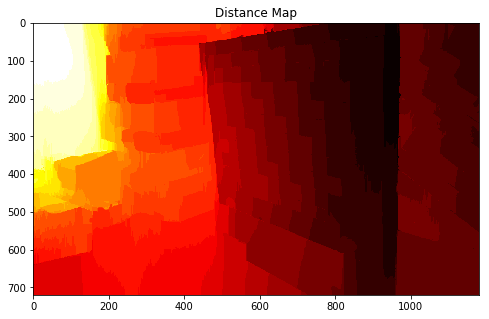

In [306]:
z = getDistanceMap(imgL, filteredImg, rc.Q, 4)
plt.title('Distance Map')
plt.imshow(z[:,100:], cmap='hot'); # clip the dead zone off

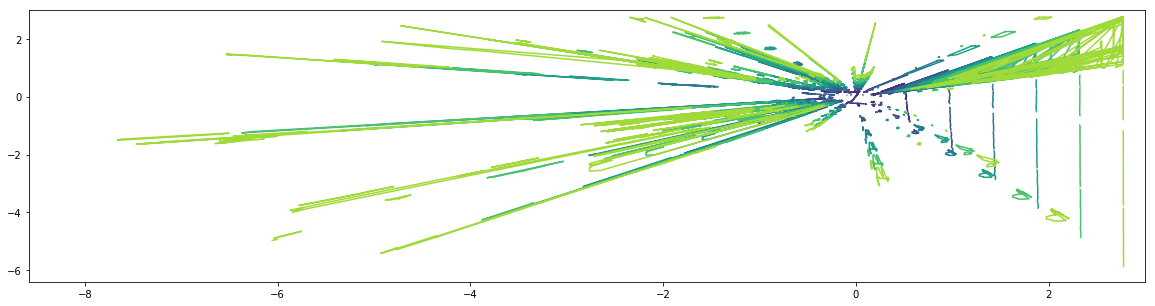

In [307]:
pts, clrs = getDistanceMap2(imgL[:,100:], disp[:,100:], rc.Q, 3)

# plt.figure(); plt.imshow(pts[:,:,0]); plt.colorbar()
# plt.figure(); plt.imshow(pts[:,:,1]); plt.colorbar()
# plt.figure(); plt.imshow(pts[:,:,2]); plt.colorbar()

plt.contour(pts[:,:,0], pts[:,:,1], pts[:,:,2])

In [276]:
class PLY(object):
    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

    def write(self, fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'w') as f:
            f.write((self.ply_header % dict(vert_num=len(verts))))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [275]:
ply = PLY()
ply.write('cb.ply',pts,clrs)

# Aloe Plant Example

{'mult': 1000, 'sigma': 0, 'lamda': 1}


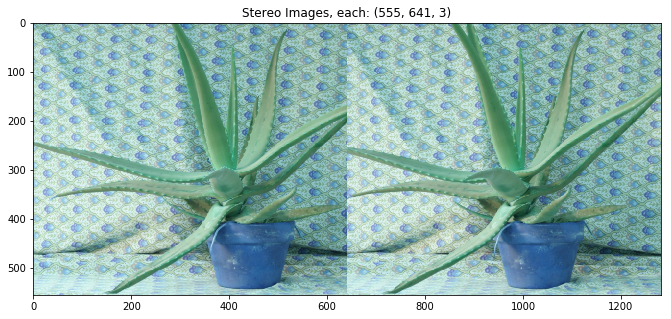

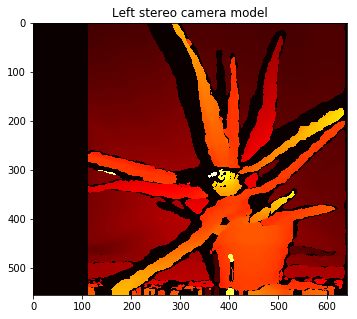

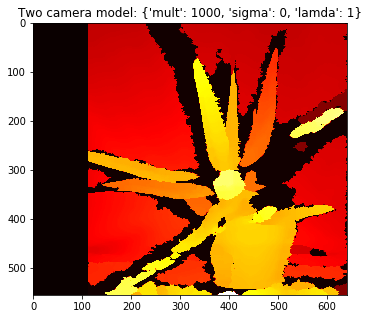

In [345]:
# we are using rectified images
aL = cv2.pyrDown( cv2.imread('stereopics/aloeL.jpg') )
aR = cv2.pyrDown( cv2.imread('stereopics/aloeR.jpg') )

# disparity range is tuned for 'aloe' image pair
# see the help for better understanding of these parameters
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereoL = cv2.StereoSGBM_create(minDisparity = min_disp,
   numDisparities = num_disp, # Maximum disparity minus minimum disparity
   blockSize = 16,
   P1 = 8*3*window_size**2,  # parameters for disparity matching
   P2 = 32*3*window_size**2,
   disp12MaxDiff = 1,  # matching differences
   uniquenessRatio = 10,  # matching parameter
   speckleWindowSize = 100,  # filtering to remove speckles in an image
   speckleRange = 32
)

plt.figure()
plt.imshow(np.hstack((aL, aR)))
plt.title('Stereo Images, each: {}'.format(aL.shape))

sdisp = stereoL.compute(aL,aR)
plt.figure()
plt.imshow(sdisp, cmap='hot')
plt.title('Left stereo camera model')

params = {
    'mult': 1000,
    'sigma': 0,
    'lamda': 1
}
pdisp = prettyDisparity(aL, aR, stereoL, **params)
plt.figure()
plt.imshow(pdisp,cmap='hot')
plt.title("Two camera model: {}".format(params));